In [1]:
import load
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# dataset = load.load_consumption_csv('./data/energy-consumption-us/merged_3yr.csv')
# dataset = load.load_consumption_csv('./data/energy-consumption-us/mini.csv')
dataset = load.load_consumption_csv('./data/energy-consumption-us/super-mini.csv')

In [3]:
dataset[:5]

[{'datetime_beginning_utc': Timestamp('2021-01-01 05:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 00:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1942.835,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 06:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 01:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1910.698,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 07:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 02:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1901.483,
  'is_verified': True},
 {'datetime_beginning_utc': Timestamp('2021-01-01 08:00:00'),
  'datetime_beginning_ept': Timestamp('2021-01-01 03:00:00'),
  'nerc_region': 'RFC',
  'mkt_region': 'MIDATL',
  'zone': 'DPL',
  'load_area': 'DPLCO',
  'mw': 1921.4

In [4]:
volume_by_timestamp = []

for row in dataset:
    ts = row['datetime_beginning_ept'] 
    volume_by_timestamp.append((ts, row['mw']))
    
volume_by_timestamp.sort(key=lambda tup: tup[0])

## Plot the data

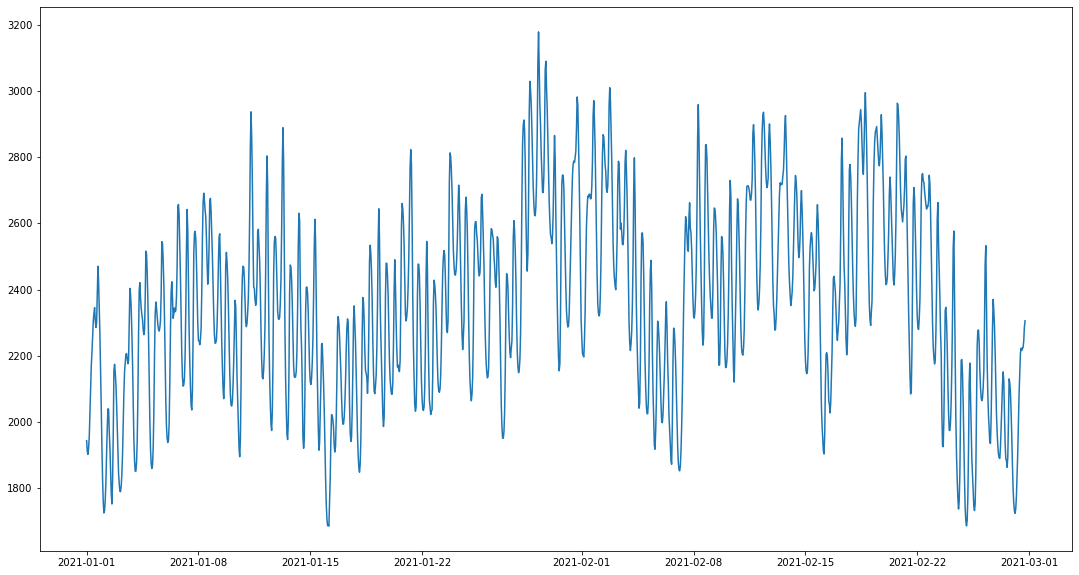

In [5]:
x, y = zip(*volume_by_timestamp)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)

## Mark Mondays

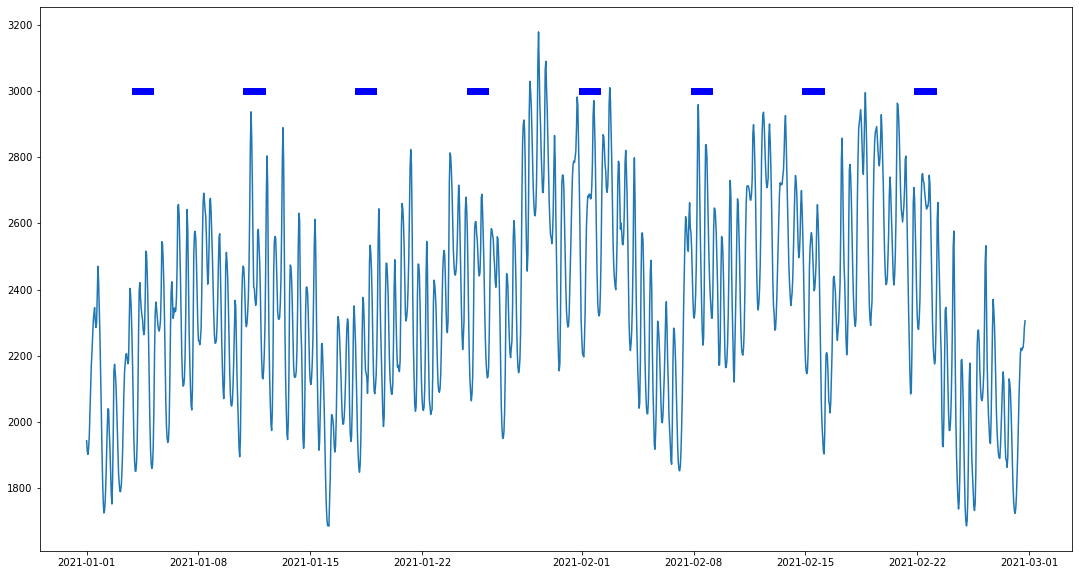

In [6]:
x_zoomed, y_zoomed = zip(*(volume_by_timestamp))

## (Monday).weekday == 0
y_2_zoomed = [3000 if ts.weekday() == 0 else None for ts in x_zoomed]


fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x_zoomed, y_zoomed)
_ = ax.plot(x_zoomed, y_2_zoomed, 'bs')

## Histogram

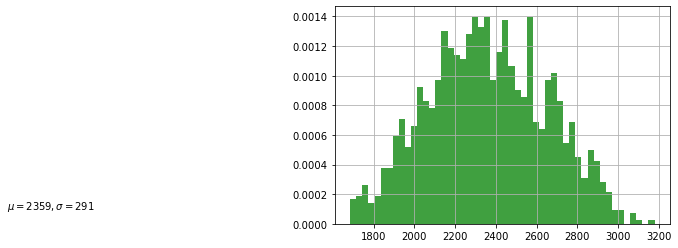

In [7]:
n, bins, patches = plt.hist(y, 50, density=True, facecolor='g', alpha=0.75)

mu = np.mean(y)
std = np.std(np.array(y))

plt.text(0, 0.0001, "$\mu=$"+str(round(mu))+'$,\sigma=$'+str(round(std)))
plt.grid(True)

## Stationarity

The diagram looks somewhat stationary, but lets do adf test. 

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

(adf_stat, p_value, _, _, critical_values, _, ) = adfuller(y)
print('ADF Statistic: %f' % adf_stat)
print('p-value: %f' % p_value)
print("Critical value %%1: %f" % critical_values['1%'])
    
if p_value < 0.05 and adf_stat < critical_values['1%']:
    print("Time series is stationary")

ADF Statistic: -5.060104
p-value: 0.000017
Critical value %1: -3.435077
Time series is stationary


## Make up some features

* Day of week
* Month of year 
* Time of day

In [9]:
import math

day_of_week = np.array([ts.weekday() for ts in x])
month = np.array([ts.month - 1 for ts in x]) # smh Jan is 1 - shift it down
time_of_day = np.array([math.floor(ts.hour / 4) for ts in x])  # split day into 6 periods

### Check how balanced are the values

In [10]:
print(np.bincount(day_of_week))
print(np.bincount(month))
print(np.bincount(time_of_day))


[192 192 192 192 216 216 211]
[744 667]
[236 236 236 236 235 232]


## Fit trend line

In [11]:
from sklearn.linear_model import LinearRegression

X_timestamps = np.array([ts.timestamp() for ts in x]).reshape(-1, 1)

reg = LinearRegression().fit(X_timestamps, y)
reg.score(X_timestamps, y)

0.026283131476911303

In [12]:
reg.coef_

array([3.21647052e-05])

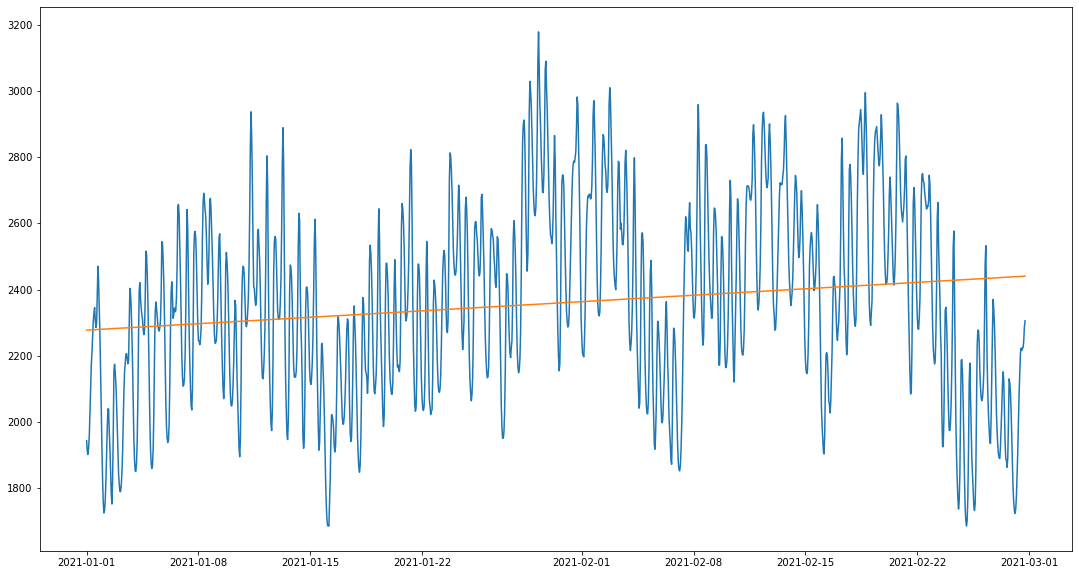

In [13]:
y_pred = reg.predict(X_timestamps)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred)

## Fit linear regression with one-hot

In [14]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

day_of_week_1h = get_one_hot(day_of_week, 7)
month_1h = get_one_hot(month, 12)
time_of_day_1h = get_one_hot(time_of_day, 6)

X_1h = np.concatenate((day_of_week_1h,month_1h,time_of_day_1h),axis=1)

In [15]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_1h, y)
reg.score(X_1h, y)

0.21571299626164997

# Plot the fit 

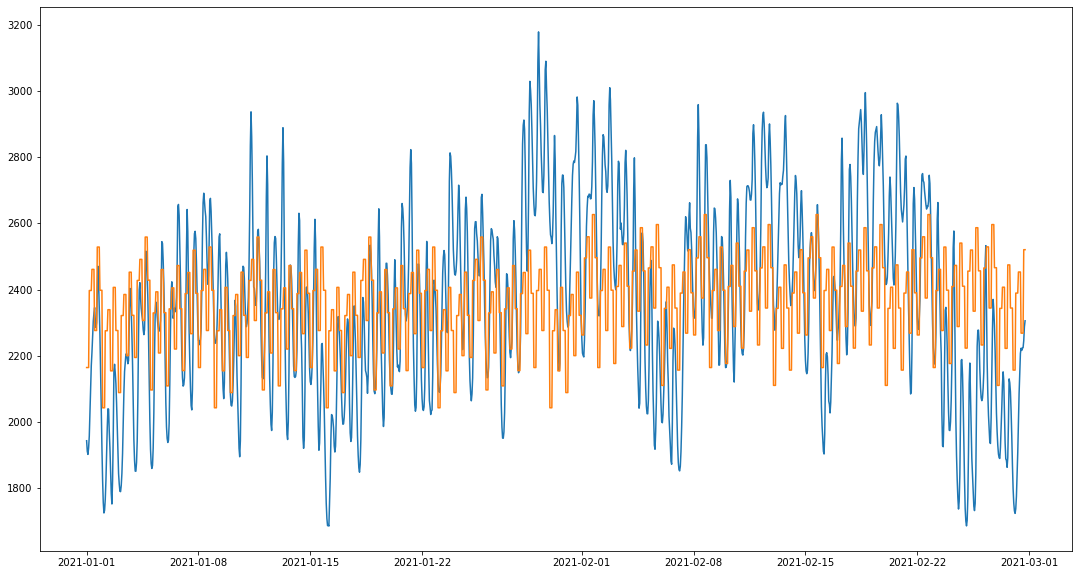

In [16]:
y_pred_1h = reg.predict(X_1h)

fig = plt.figure()
fig.set_size_inches(18.5, 10)
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.plot(x, y_pred_1h)

## Fit 1D GP

In [17]:
import GPy

GPy.plotting.change_plotting_library('plotly_offline')

 /home/model/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



# Poor man's normalization (TODO: fix this)

In [58]:
X_timestamps_normalized = (X_timestamps-np.min(X_timestamps))/(6. * 10**5)
y_normalized = np.array(y, ndmin=2).T/1000.-2.2

# TODO: why such low lengthscale works?

# TODO: run on some test data

In [59]:
kernel_rbf = GPy.kern.RBF(input_dim=1, variance=5, lengthscale=10)
kernel_brownian = GPy.kern.Brownian(input_dim=1, variance=10)
kernel_lin = GPy.kern.Linear(input_dim=1)
kernel = kernel_lin * kernel_rbf 

m = GPy.models.GPRegression(X_timestamps_normalized,y_normalized,kernel)

m.optimize(messages=True)
#m.optimize_restarts(num_restarts = 1)

In [60]:
fig = m.plot(title='1d_gp')

GPy.plotting.show(fig, filename='1d_gp')

## Fit 4D GP